In [2]:
import pandas as pd
import os
import ast
from collections import Counter
import seaborn as sns
import ast
import numpy as np
import matplotlib.pyplot as plt

### 1. Concat and remove duplicate labels in every boxes column

#### 1.1 Related functions for data preprocessing

In [3]:
# 定义各朝代对应的文件路径
dynasty_files = {
    "liaojin": [
        "output_liaojin.csv",
        "output_liaojin_museum.csv"
    ],
    "suitang": [
        "output_suitang.csv",
        "output_suitang_museum.csv"
    ],
    "song": [
        "book_song.csv",
        "museum_song1.csv"
    ],
    "ming": [
        "book_ming.csv",
        "museum_ming1.csv"
    ],
    "yuan": [
        "book_yuan.csv",
        "museum_yuan1.csv"
    ],
    "qing": [
        "book_qing.csv",
        "museum_qing1.csv"
    ]
}

# ========== 核心函数 ==========

def load_and_combine_files(dynasty_files):
    combined_dfs = []
    for dynasty, file_list in dynasty_files.items():
        for file_path in file_list:
            try:
                df = pd.read_csv(file_path)
                print(f"✅ 读取成功: {file_path}, 行数: {len(df)}")
                if 'label' in df.columns and 'labels' not in df.columns:
                    df.rename(columns={'label': 'labels'}, inplace=True)
                elif 'labels' not in df.columns:
                    df['labels'] = None
                df['labels'] = df['labels'].astype(str)
                df['source_file'] = os.path.basename(file_path)
                df['dynasty'] = dynasty
                combined_dfs.append(df)
            except Exception as e:
                print(f"❌ 读取失败: {file_path}, 错误: {e}")
    if not combined_dfs:
        raise ValueError("❗ 没有成功加载任何文件，请检查路径和文件内容！")
    return pd.concat(combined_dfs, ignore_index=True)

# 强制统一 boxes 列：全部转成字符串保存，因为之前显示检测到 172 行 boxes 非字符串
def ensure_boxes_str(value):
    if isinstance(value, str):
        return value
    elif isinstance(value, list):
        return str(value)
    else:
        return '[]'  # 空或异常直接用空列表

def extract_box_labels_unique(boxes_input):
    try:
        if isinstance(boxes_input, str):
            boxes_list = ast.literal_eval(boxes_input)
        elif isinstance(boxes_input, list):
            boxes_list = boxes_input
        else:
            return []
        unique_labels = list({box['label'] for box in boxes_list})
        return [{'label': label} for label in unique_labels]
    except Exception:
        return []

def extract_box_labels(boxes_input):
    try:
        if isinstance(boxes_input, str):
            boxes_list = ast.literal_eval(boxes_input)
        elif isinstance(boxes_input, list):
            boxes_list = boxes_input
        else:
            return []
        return [box['label'] for box in boxes_list]
    except Exception:
        return []

def extract_label_numbers(label_list):
    if isinstance(label_list, list):
        return label_list
    try:
        parsed = ast.literal_eval(label_list)
        if isinstance(parsed, list):
            return parsed
    except Exception:
        return []
    return []

def count_boxes(df):
    all_labels = []
    for item in df['boxes']:
        all_labels.extend(extract_box_labels(item))
    return Counter(all_labels)

def count_labels(df):
    all_numbers = []
    for item in df['labels']:
        all_numbers.extend(extract_label_numbers(item))
    return Counter(all_numbers)
    

#### 1.2 Main process for getting our dataframe 

In [4]:
# 加载数据
all_combined = load_and_combine_files(dynasty_files)

all_combined['boxes'] = all_combined['boxes'].apply(ensure_boxes_str)

# 检测 boxes 列异常
invalid_boxes = all_combined[~all_combined['boxes'].apply(lambda x: isinstance(x, str))]
print(f"⚠ 检测到 {len(invalid_boxes)} 行 boxes 非字符串")

# 去重 boxes 中的重复 label
all_combined['boxes'] = all_combined['boxes'].apply(extract_box_labels_unique)

all_combined.dtypes

✅ 读取成功: output_liaojin.csv, 行数: 62
✅ 读取成功: output_liaojin_museum.csv, 行数: 55
✅ 读取成功: output_suitang.csv, 行数: 77
✅ 读取成功: output_suitang_museum.csv, 行数: 90
✅ 读取成功: book_song.csv, 行数: 84
✅ 读取成功: museum_song1.csv, 行数: 47
✅ 读取成功: book_ming.csv, 行数: 122
✅ 读取成功: museum_ming1.csv, 行数: 75
✅ 读取成功: book_yuan.csv, 行数: 87
✅ 读取成功: museum_yuan1.csv, 行数: 58
✅ 读取成功: book_qing.csv, 行数: 182
✅ 读取成功: museum_qing1.csv, 行数: 314
⚠ 检测到 0 行 boxes 非字符串


ID             object
boxes          object
labels         object
source_file    object
dynasty        object
dtype: object

### 2. Statistical and data analysis and visualization
#### 2.1 Counting for boxes and labels

In [5]:
# 按朝代统计
boxes_stats = {}
labels_stats = {}

for dynasty, group_df in all_combined.groupby('dynasty'):
    boxes_stats[dynasty] = count_boxes(group_df)
    labels_stats[dynasty] = count_labels(group_df)

# 总体统计
boxes_stats['all'] = count_boxes(all_combined)
labels_stats['all'] = count_labels(all_combined)

# 转为 DataFrame
boxes_df = pd.DataFrame(boxes_stats).fillna(0).astype(int)
labels_df = pd.DataFrame(labels_stats).fillna(0).astype(int)

# # 保存统计结果
# boxes_df.to_csv("boxes_label_frequency_by_dynasty.csv")
# labels_df.to_csv("labels_number_distribution_by_dynasty.csv")

In [6]:
boxes_df

liaojin  ming  qing  song  suitang  yuan  all
figure                           3     0     1     0        1     0    5
deer                            15     0     1     1        3     1   21
mountain tree                    1     0     0     0        0     0    1
翟鸟                               2     0     0     0        0     1    3
plant                            1     2     1     0        1     0    5
...                            ...   ...   ...   ...      ...   ...  ...
金乌鸟                              0     0     0     0        0     1    1
Repeating Abstract Motifs        0     0     0     0        0     1    1
麒麟纹                              0     0     0     0        0     1    1
方搭纹                              0     0     0     0        0     1    1
Honeycomb                        0     0     0     0        0     1    1

[988 rows x 7 columns]

In [7]:
labels_df 

liaojin  ming  qing  song  suitang  yuan   all
5          19    39   240    20       39    27   384
0         201   165  1014    74      268   314  2036
1         199   639  2655   498      395   666  5052
3          58   117   343    13      172   149   852
2          63   504  1272    73       54   100  2066
4           2    51   151    43       79    18   344
None        0    30     0     0        0    58    88
0: 5        0     0     1     0        0     0     1
1: 5        0     0     1     0        0     0     1
2: 0        0     0     1     0        0     0     1
3: 5        0     0     1     0        0     0     1
4: 5        0     0     1     0        0     0     1
5: 2        0     0     1     0        0     0     1
6: 2        0     0     1     0        0     0     1
7: 0        0     0     1     0        0     0     1
-1          0     0    11     0        0     0    11
9           0     0     0   143        0     0   143
6           0     0     0     0        1     0     1

#### 2.2 Initial visualization to identify problems

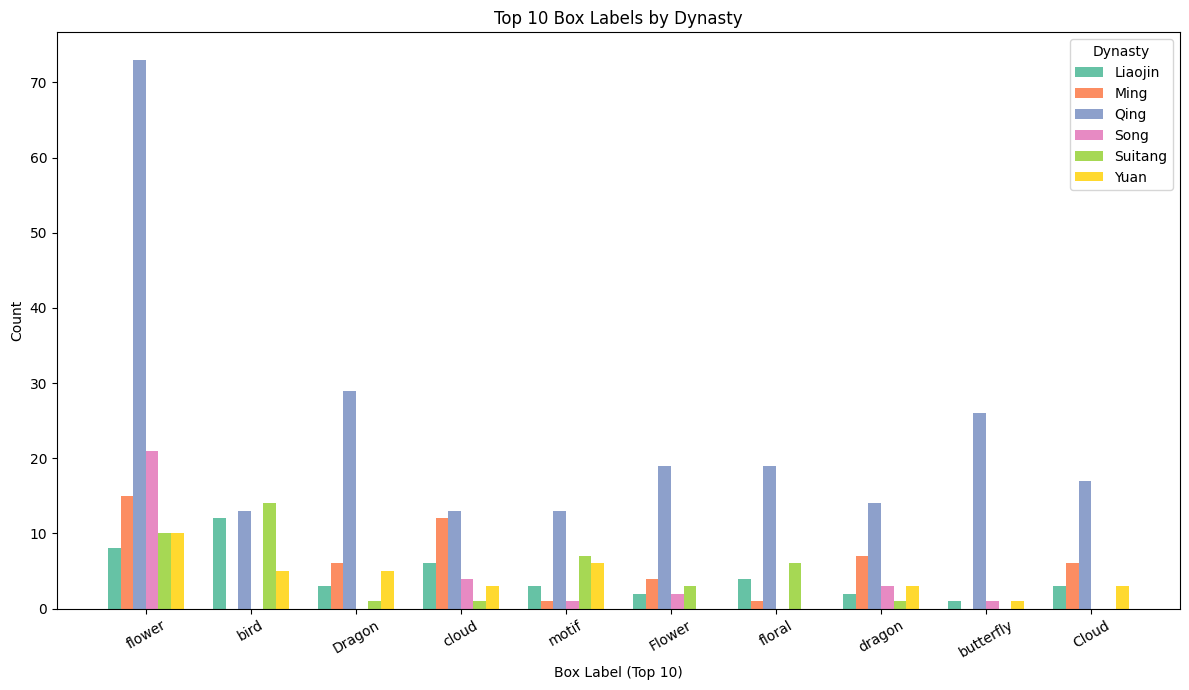

In [8]:
top_labels = boxes_df['all'].sort_values(ascending=False).head(10).index.tolist()
dynasties = [col for col in boxes_df.columns if col != 'all']
filtered_boxes_df = boxes_df.loc[top_labels, dynasties]

# 使用 seaborn 高级配色
colors = sns.color_palette("Set2", n_colors=len(dynasties))

# 绘图
x = np.arange(len(top_labels))
width = 0.12

plt.figure(figsize=(12, 7))
for i, dynasty in enumerate(dynasties):
    plt.bar(x + i * width, filtered_boxes_df[dynasty], width,
            label=dynasty.capitalize(), color=colors[i % len(colors)])

plt.xlabel('Box Label (Top 10)')
plt.ylabel('Count')
plt.title('Top 10 Box Labels by Dynasty')
plt.xticks(x + width * (len(dynasties) - 1) / 2, top_labels, rotation=30)
plt.legend(title='Dynasty')
plt.tight_layout()
plt.show()

现在boxes的可视化无意义：
1. 大小写未统一
2. 有很多无意义的标签
3. 中文标签未翻译

In [9]:
# 确保索引是字符串
labels_df.index = labels_df.index.astype(str)

# 定义替换映射
category_map = {
    '0': "animals",
    '1': "plants",
    '2': "inanimate objects",
    '3': "geometric patterns",
    '4': "textual motifs",
    '5': "human motifs",
    'None': "Uncategorized"
}

# 提取 dynasties 列
if 'all' in labels_df.columns:
    dynasties = [col for col in labels_df.columns if col != 'all']
else:
    dynasties = list(labels_df.columns)

# 筛选和重命名索引
filtered_labels_df = labels_df.loc[labels_df.index.isin(category_map.keys())].copy()
filtered_labels_df = filtered_labels_df.rename(index=category_map)
percent_df = filtered_labels_df[dynasties].div(filtered_labels_df[dynasties].sum(axis=0), axis=1)

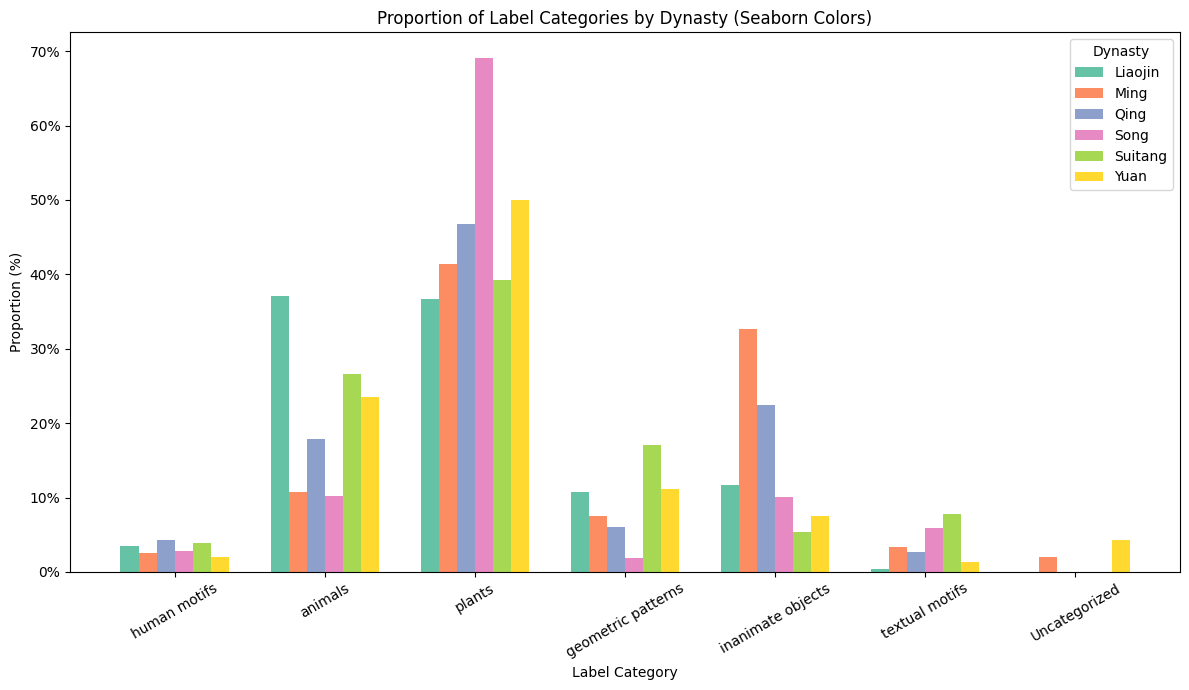

In [10]:
# 使用 seaborn 高级配色（这里用 Set2，你也可以换成 pastel, Dark2 等）
colors = sns.color_palette("Set2", n_colors=len(dynasties))

# 绘图
categories = filtered_labels_df.index.tolist()
x = np.arange(len(categories))
width = 0.12

plt.figure(figsize=(12, 7))
for i, dynasty in enumerate(dynasties):
    plt.bar(x + i * width, percent_df[dynasty], width, label=dynasty.capitalize(), color=colors[i % len(colors)])

plt.xlabel('Label Category')
plt.ylabel('Proportion (%)')
plt.title('Proportion of Label Categories by Dynasty (Seaborn Colors)')
plt.xticks(x + width * (len(dynasties) - 1) / 2, categories, rotation=30)
plt.legend(title='Dynasty')
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
plt.tight_layout()
plt.show()

### 3. Converting boxes' label names to English and Cleaning the content

#### 3.1 View the original unique boxes labels to locate the problem

In [11]:
all_box_labels = []

for b in all_combined['boxes']:
    try:
        # 如果是字符串，解析成 list；如果是 list，直接用
        if isinstance(b, str):
            boxes_list = ast.literal_eval(b)
        elif isinstance(b, list):
            boxes_list = b
        else:
            continue
        
        # 提取 label，转小写
        all_box_labels.extend([str(box['label']).lower() for box in boxes_list if 'label' in box])
    except Exception:
        continue

# 转成 DataFrame
box_labels_df = pd.DataFrame({'normalized_label': all_box_labels})

# 统计唯一标签及频次
unique_labels_df = box_labels_df['normalized_label'].value_counts().reset_index()
unique_labels_df.columns = ['box_label', 'count']

# 保存到 CSV
unique_labels_df.to_csv("unique_box_labels_lowercased.csv", index=False)
print("✅ 已生成 unique_box_labels_lowercased.csv，供检查所有 box label 用。")

✅ 已生成 unique_box_labels_lowercased.csv，供检查所有 box label 用。


#### 3.2 Define the conversion map

In [51]:
# 4️⃣ 定义翻译映射（扩展版，包括瓣窠等专有词）
translation_map = {
    '云': 'cloud',
    '花': 'flower',
    '牡丹': 'peony',
    '蝴蝶': 'butterfly',
    '鹤': 'crane',
    '凤凰': 'phoenix',
    '龙': 'dragon',
    '凤': 'phoenix',
    '山': 'mountain',
    '水波': 'wave',
    '人物': 'figure',
    '鸟': 'bird',
    '梅': 'plum blossom',
    '竹': 'bamboo',
    '鱼': 'fish',
    '鹿': 'beast',
    '虎': 'tiger',
    '狮': 'lion',
    '莲': 'lotus',
    '莲花': 'lotus',
    '菊花':'chrysanthemum',
    '瓣窠': 'petal cluster',
    '瓣窠纹': 'petal cluster',
    '瓣窠式': 'petal cluster',
    '芙蓉': 'hibiscus',
    '团纹': 'medallion',
    '博古': 'antiquities',
    # '博古纹': 'antiquities',
    '赤兔': 'red hare',
    '福': 'fu',
    '直线': 'straight line',
    '葡萄': 'grape',
    '锯齿球形': 'serrated sphere',
    '凤尾': 'phoenix tail',
    '蟠螭纹': 'coiled dragon',
    '方胜': 'square victory',
    '飞燕': 'flying swallow',
    '对马纹': 'paired horse',
    '仕女': 'court lady',
    '佛手': "Buddha's hand",
    '萱草纹': 'daylily',
    '童子骑羊': 'child riding goat',
    '锦鸡': 'golden pheasant',
    '金锭': 'gold ingot',
    '童子': 'child motif',
    '牛形动物纹样': 'ox-shaped animal',
    '夹缬': 'resist-dyed',
    '婴戏图': 'baby play scene',
    '如意吉祥纹': 'ruyi auspicious',
    '缠枝叶': 'intertwined branch and leaf',
    '斗牛纹': 'bullfighting',
    '柿蒂窠': 'persimmon calyx',
    '婴戏': 'baby play',
    '万字': 'swastika',
    '石榴': 'pomegranate',
    '对桃': 'paired peach',
    '奔兽': 'beast',
    '凤纹': 'phoenix',
    '海棠': 'begonia',
    '蝙蝠': 'bat',
    '琐纹': 'small linked',
    '盘长': 'endless knot',
    '盘凤': 'coiled phoenix',
    '海水纹样': 'sea wave',
    '球路流苏纹': 'ball-and-tassel',
    '翟纹': 'pheasant',
    '毬路': 'ball',
    '灵芝': 'lingzhi',
    '龟背纹': 'tortoise shell',
    '波斯文': 'Persian script',
    '缠枝': 'intertwined branches',
    '五湖四海纹': 'five lakes and four seas',
    '王': 'king symbol',
    '叶子': 'leaf',
    '菱格': 'rhombus',
    '葫芦': 'gourd',
    '蟒': 'python',
    '雁': 'wild goose',
    '龟甲纹': 'turtle shell',
    '卍': 'swastika',
    # '卍字': 'swastika',
    # '卍 字': 'swastika',
    # '卍字纹': 'swastika',
    '团窠': 'clustered medallion',
    '流水': 'flowing water',
    '灯笼': 'lantern',
    '杂宝': 'assorted treasures',
    '枝干': 'branches',
    # '寿字': 'longevity symbol',
    '寿': 'longevity symbol',
    '蝶': 'butterfly',
    '松枝': 'pine branch',
    '四合如意纹': 'four-in-one ruyi',
    # '力芬': 'lifen', 感觉是错误的可以delete
    '盘球纹': 'coiled ball',
    '联珠团窠': 'beaded clustered medallion',
    '柿蒂': 'persimmon calyx',
    '钱纹': 'coin',
    '八吉祥': 'eight auspicious symbols',
    '拱璧纹': 'arched jade disc',
    '卷草': 'scrolling grass',
    '卷草如意纹': 'scrolling grass',
    '梅竹纹样': 'plum and bamboo',
    '小窠宝花纹锦': 'small-cluster precious flower brocade',
    '宝花':'precious flower',
    '梅花': 'plum blossom',
    '盘长': 'endless knot',
    '折枝花卉纹样': 'broken branch floral',
    '赤兔纹': 'red hare',
    '对狮': 'paired lion',
    '灵芝云': 'lingzhi cloud',
    '喜相逢团纹': 'happy meeting medallion',
    '芙蓉花': 'hibiscus',
    '牡丹花': 'peony',
    '落花': 'falling flower',
    '宝相花': 'precious lotus',
    '圆芯朵梅纹': 'round-core plum blossom',
    '缠枝牡丹纹': 'intertwined peony',
    '串枝莲花纹': 'clustered lotus',
    '翟鸟': 'pheasant bird',
    '葫芦花': 'gourd flower',
    '团凤': 'paired phoenix',
    '波浪花纹': 'wave pattern',
    '波纹': 'wave pattern',
    '锁子纹': 'chain pattern',
    '兽': 'beast',

    '罐': 'pot',
    '鸂鶒': 'mandarin duck',
    '黑缎镶边': 'black satin edging',
    '土': 'earth / soil',
    '扇子': 'fan',
    '勾连纹': 'interlinked pattern',
    '盖': 'lid / cover',
    '阴阳叉': 'yin-yang fork',
    '日': 'sun',
    '胡旋舞人': 'Sogdian dancer',
    '江涯海水与桃树': 'seashore, water, and peach tree',
    '练雀': 'sparrow',
    '圆补': 'round patch',
    '‘富’‘贵’‘万岁’等文字纹样': 'character motifs',
    '飞鹰': 'flying eagle',
    '海水江崖': 'sea and cliff',
    '栏杆裙': 'railing-skirt',
    '宝瓶': 'precious vase',
    '圆盒': 'round box',
    '书籍': 'book / books',
    '如意': 'ruyi',
    '拱桥': 'arched bridge',
    '建筑': ' building',
    '波光粼粼的水面': 'shimmering water surface',
    '楼阁': 'pavilion',
    '撑船': 'boating',
    '孔雀': 'peacock',
    '孔 雀': 'peacock',
    '盆景': 'bonsai',
    '摆件': 'ornament',
    '谷穗': 'ear of grain',
    '水浪': 'water wave',
    '仙人': 'immortal / celestial being',
    # '道家帽子': 'Taoist hat',
    # '汉式长袍': 'Han-style robe', 同理，感觉也不是纹样
    '羽扇': 'feather fan',
    '拱 璧 纹': 'arched jade disc motif',
    '双矩': 'double square / double ruler',
    '鹭鸶': 'egret',
    '菱纹格': 'rhombus grid',
    '麒麟纹': 'qilin motif',
    '方搭纹': 'square lattice pattern',
    '月亮': 'moon',
    '日纹': 'sun',
    '桂树': 'cassia tree',
    '双胜纹': 'double-victory motif', # 不确定的翻译
    '窠形': 'cluster shape',
    '一年景': 'four seasons scene',
    '独 角 麒 麟': 'one-horned qilin',
    '海东青': 'gyrfalcon',
    '奔兔': 'running rabbit',
    '孔雀纹': 'peacock motif',
    # '纹': 'motif / pattern', # 无意义，可以删除
    '猪头': 'pig head',
    # '絹裤残片': 'silk trouser fragment', #不是纹样
    '珊瑚': 'coral',
    '书卷': 'book roll',
    '犀角': 'rhinoceros horn',
    '绿叶': 'green leaf',
    '海 螺': 'conch',
    '联珠纹': 'beaded motif',
    '回纹装饰': 'meander decoration',
    '叶': 'leaf',
    '联珠圈': 'beaded circle',
    '玉树': 'jade tree',
    # '圆领': 'round collar', 不是纹样
    '阿拉伯文': 'Arabic script',
    # '高筒绢袜': 'tall silk socks', 不是纹样
    # '罗鞋': 'silk shoes', # 不是纹样
    '秋': 'character motif',
    '岁': 'character motif',
    '千': 'character motif',
    '万': 'character motif',
    '球路': 'ball-shaped motif',
    '四 合 如 意 纹': 'four-in-one ruyi motif',
    '联珠': 'beaded motif',
    '异兽': 'exotic beast',
    '鹊': 'magpie',
    '带式联珠纹': 'belt-like beaded motif',
    '联珠纹样': 'beaded motif',
    '摩羯': 'makara (mythical creature)',
    '海水': 'sea wave',
    '玉兔': 'jade rabbit',

    '团花': 'clustered flower',
    '十字宾花': 'cross guest flower',
    '菱形方格纹': 'rhombus lattice pattern',
    '描金折枝花纹': 'gold-painted broken branch floral pattern',
    '蓮花': 'lotus',
    '桃形纹': 'peach-shaped pattern',
    '花蕾': 'flower bud',
    '海螺': 'conch',
    '金刚杵': 'vajra',
    '菱形': 'rhombus',
    '独角麒麟': 'one-horned qilin',
    '四季花': 'four seasons flowers',
    '小花纹': 'small flower pattern',
    '十字花纹': 'cross pattern',
    '拱璧纹': 'arched jade disc motif',
    '大洋花': 'ocean flower',
    '团荷花双喜字纹': 'clustered lotus with double happiness character pattern',
    '孔雀': 'peacock',
    '皮球花': 'ball flower',
    '花蓝': 'flower basket',
    '花草': 'flowers and grasses',
    'floral pattern':'floral',
    'floral motif':'floral',
    'clouds':'cloud'
    
}

# 5️⃣ 注释掉这一部分可以输出最原始的没有匹配的boxes的label显示
def translate_label(label):
    label_str = str(label).strip()
    
    # 1️⃣ 完全匹配优先
    if label_str in translation_map:
        return translation_map[label_str]
    
    # 2️⃣ 优先长词部分匹配
    for cn, en in sorted(translation_map.items(), key=lambda x: len(x[0]), reverse=True):
        if cn in label_str:
            return en
    
    # 3️⃣ 没匹配到，保留原值或指定兜底
    return label_str  # 或 return 'unknown'


In [20]:
# main_keywords = ['flower', 'blossom', 'bird', 'phoenix', 'dragon', 'figure', 'child', 'animal',
#                  'butterfly', 'fish', 'deer', 'beast', 'cloud', 'mountain', 'tortoise', 'ox',
#                  'hare', 'horse', 'pheasant']

# framework_keywords = ['pattern', 'knot', 'medallion', 'cluster', 'brocade', 'disc', 'frame',
#                       'scroll', 'lattice', 'grid', 'ruyi', 'chain', 'endless', 'coiled', 'beaded',
#                       'diamond', 'rhombus', 'cross', 'circular', 'wave', 'tassel', 'resist-dyed']

# def classify_motif(english_label):
#     lower_label = english_label.lower()
#     for kw in main_keywords:
#         if kw in lower_label:
#             return 'Main Part'
#     for kw in framework_keywords:
#         if kw in lower_label:
#             return 'Frame'
#     return 'unclassified'

In [52]:
box_labels_df_translated_label = box_labels_df.copy()
box_labels_df_translated_label['translated_label'] = box_labels_df_translated_label['normalized_label'].apply(translate_label)

# 6️⃣ 统计唯一项及频次
unique_labels = box_labels_df_translated_label['translated_label'].value_counts().reset_index()
# unique_labels = box_labels_df['normalized_label'].value_counts().reset_index()

unique_labels.columns = ['label', 'count']

# 7️⃣ 保存为 unique_box_labels.csv
unique_labels.to_csv("unique_box_labels.csv", index=False)

print("✅ 已完成大小写统一、翻译，并保存 unique_box_labels.csv")


✅ 已完成大小写统一、翻译，并保存 unique_box_labels.csv


#### 3.3 After manual cleaning on the map base, read the final csv and clean boxes_df

In [53]:
# 重新加载手动修改过的 CSV
filtered_csv = pd.read_csv("unique_box_labels_cleaned.csv")
valid_labels = set(filtered_csv['label'])

# 在 box_labels_df_translated_label 中筛选，只保留在 CSV 中存在的标签
filtered_box_labels_df = box_labels_df_translated_label[
    box_labels_df_translated_label['translated_label'].isin(valid_labels)
].copy()

print(f"✅ 已筛选，剩余 {len(filtered_box_labels_df)} 行")

✅ 已筛选，剩余 2180 行


In [54]:
filtered_box_labels_df.to_csv("unique_box_labels_final.csv", index=False)

#### 3.4 Final visualization and analysis

1. World cloud for all and each dynasty

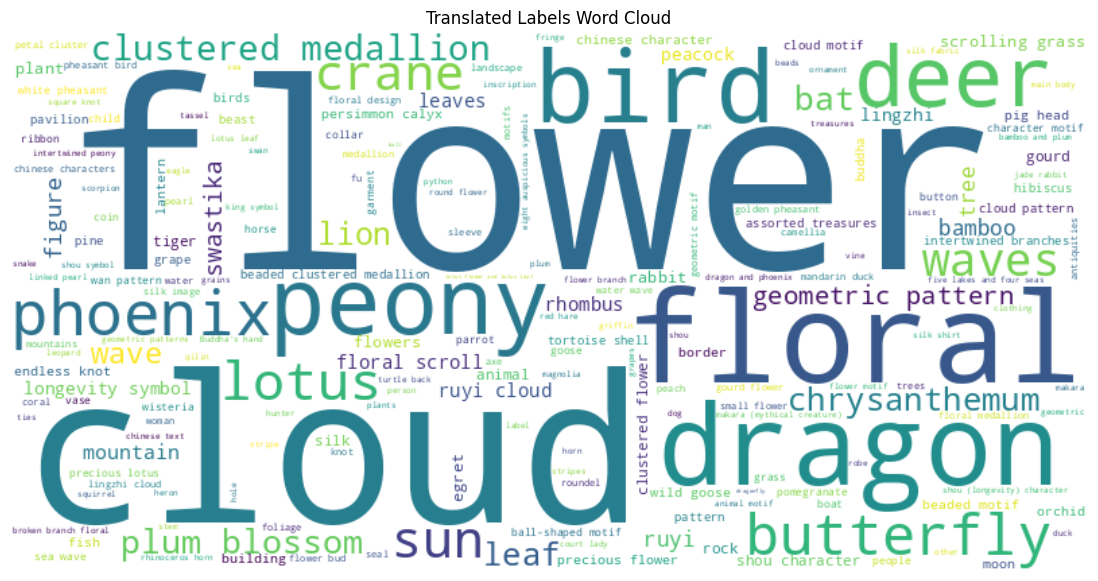

In [55]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 准备词频字典
word_freq = filtered_box_labels_df['translated_label'].value_counts().to_dict()

# 生成词云
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

# 展示词云
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Translated Labels Word Cloud')
plt.show()


In [56]:
print("可用列:", boxes_df.columns)
filtered_box_labels_df

可用列: Index(['liaojin', 'ming', 'qing', 'song', 'suitang', 'yuan', 'all'], dtype='object')


normalized_label translated_label
0              figure           figure
1                deer             deer
2       mountain tree    mountain tree
3                  翟鸟    pheasant bird
4                  翟鸟    pheasant bird
...               ...              ...
2241               牡丹            peony
2242        butterfly        butterfly
2243      flower tree      flower tree
2244      turtle back      turtle back
2245         swastika         swastika

[2180 rows x 2 columns]

In [57]:
def translate_label(label):
    label_str = str(label).strip()
    if label_str in translation_map:
        return translation_map[label_str]
    for cn, en in sorted(translation_map.items(), key=lambda x: len(x[0]), reverse=True):
        if cn in label_str:
            return en
    return label_str

translated_boxes_df = boxes_df.copy()
translated_boxes_df.index = translated_boxes_df.index.map(translate_label)

# 加载手动清洗后的 CSV 作为过滤器
filtered_csv = pd.read_csv("unique_box_labels_cleaned.csv")
valid_labels = set(filtered_csv['label'])


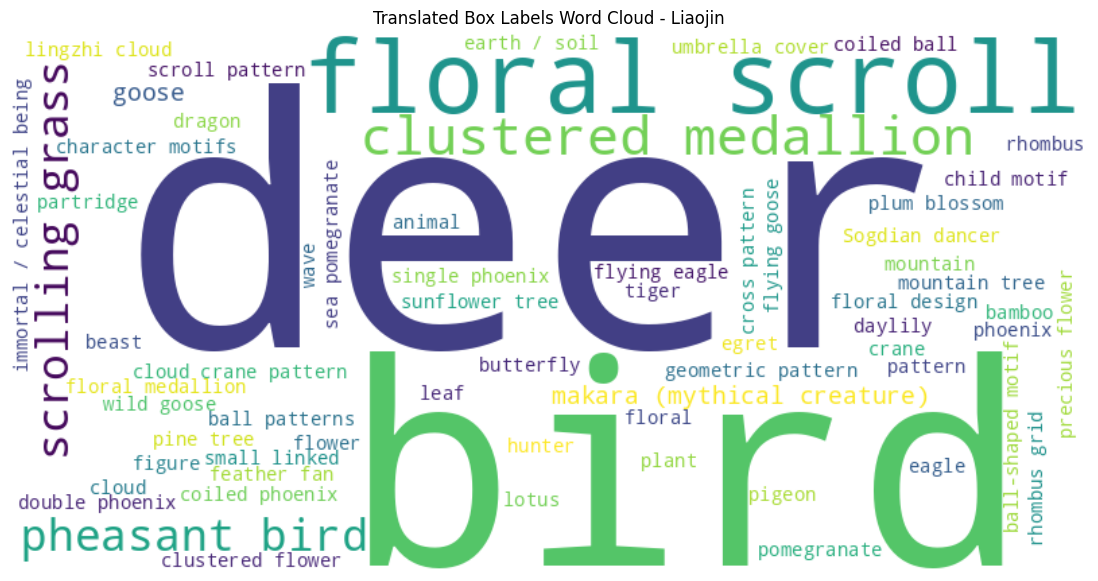

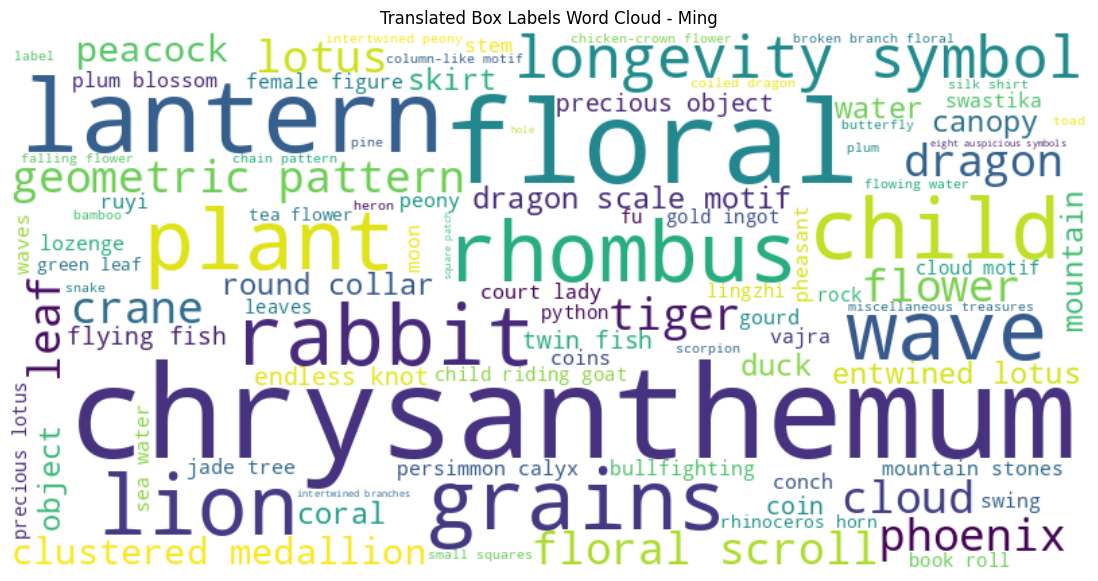

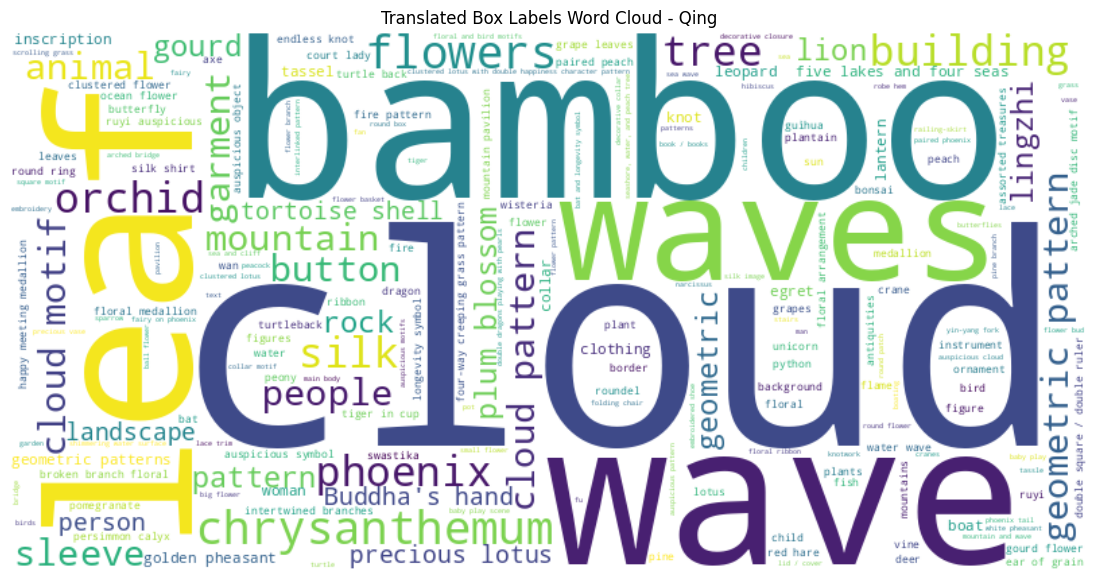

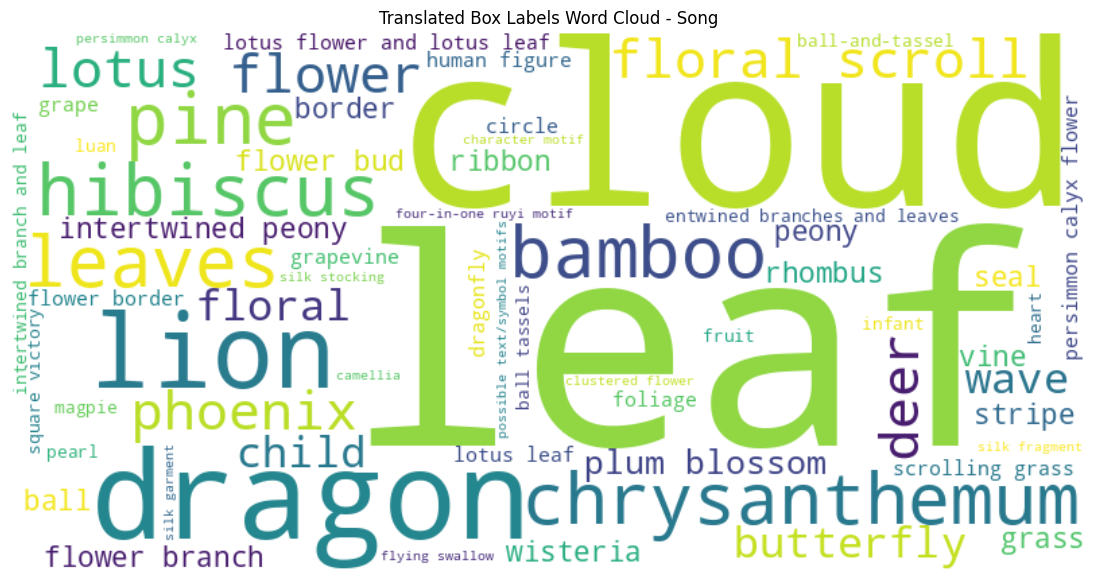

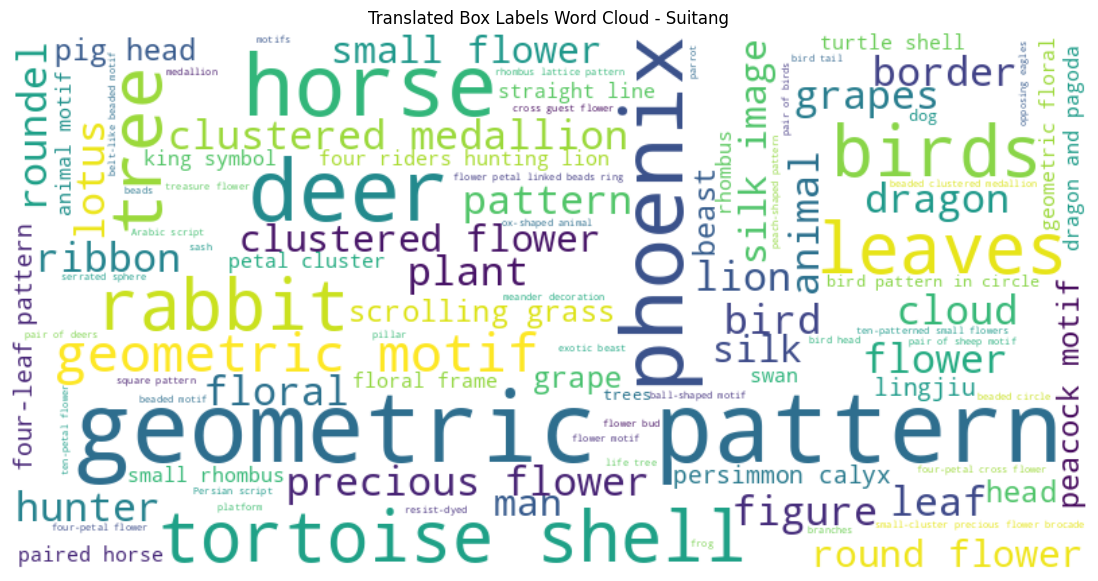

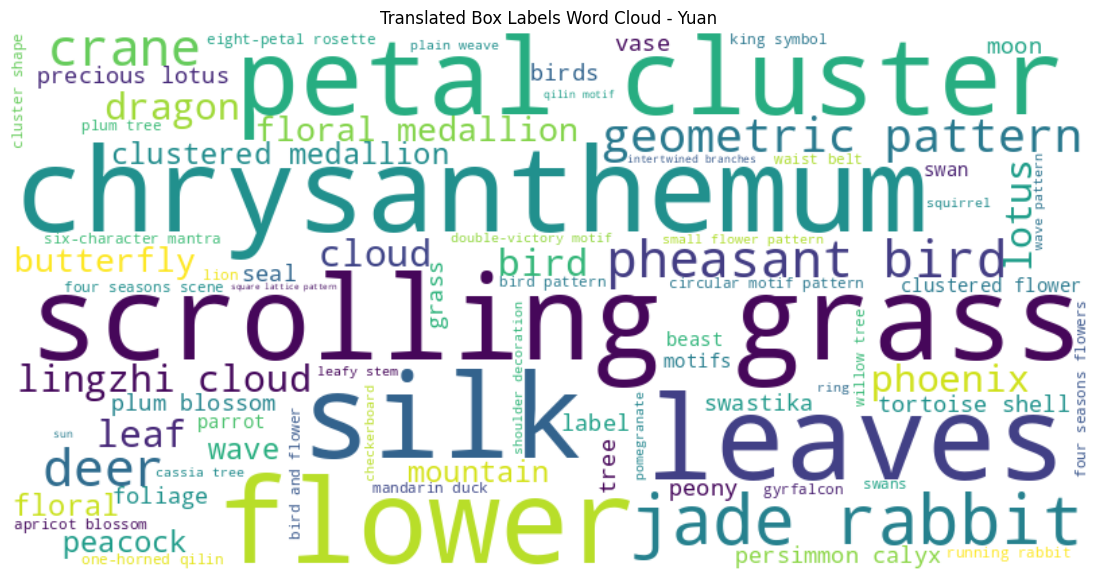

In [58]:
# 保留在 CSV 中存在的标签
translated_boxes_df = translated_boxes_df.loc[translated_boxes_df.index.isin(valid_labels)].copy()

# 去掉 'all' 列，只用具体朝代
dynasties = [col for col in translated_boxes_df.columns if col != 'all']

# 按每个朝代生成词云
for dynasty in dynasties:
    word_freq = translated_boxes_df[dynasty][translated_boxes_df[dynasty] > 0].to_dict()

    if word_freq:
        wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)

        plt.figure(figsize=(15, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'Translated Box Labels Word Cloud - {dynasty.capitalize()}')
        plt.show()

2. 相似度热力图

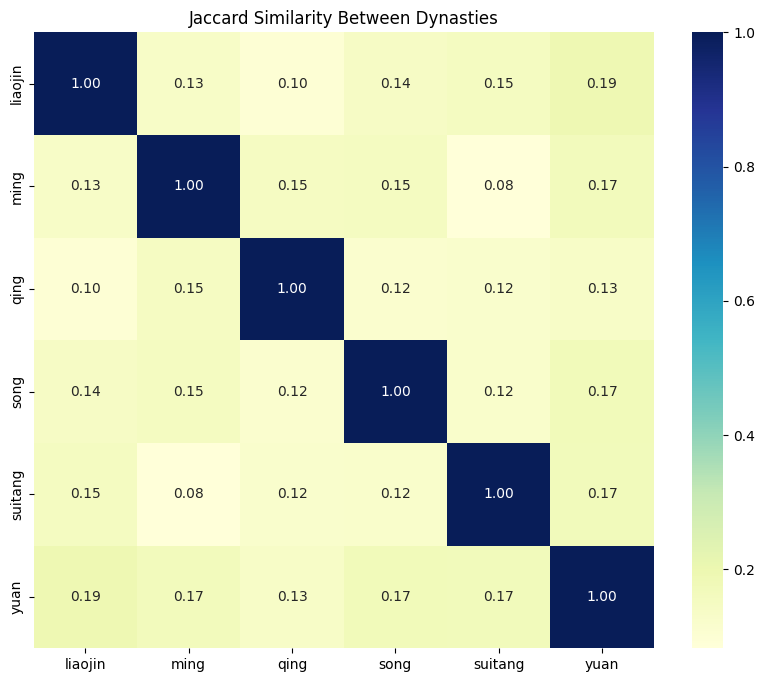

In [59]:
from itertools import combinations
from upsetplot import UpSet, from_memberships

dynasty_label_sets = {
    dynasty: set(translated_boxes_df.index[translated_boxes_df[dynasty] > 0])
    for dynasty in translated_boxes_df.columns if dynasty != 'all'
}

# 计算 Jaccard 相似度矩阵
dynasties = list(dynasty_label_sets.keys())
jaccard_matrix = pd.DataFrame(0.0, index=dynasties, columns=dynasties)

for d1, d2 in combinations(dynasties, 2):
    set1, set2 = dynasty_label_sets[d1], dynasty_label_sets[d2]
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    jaccard = intersection / union if union != 0 else 0
    jaccard_matrix.loc[d1, d2] = jaccard
    jaccard_matrix.loc[d2, d1] = jaccard
np.fill_diagonal(jaccard_matrix.values, 1.0)

# 绘制热力图
plt.figure(figsize=(10, 8))
sns.heatmap(jaccard_matrix, annot=True, cmap='YlGnBu', fmt='.2f')
plt.title('Jaccard Similarity Between Dynasties')
plt.show()


3. Top-N 高频标签 UpSet plot 代码

/opt/anaconda3/envs/silk_env/lib/python3.10/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/opt/anaconda3/envs/silk_env/lib/python3.10/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fil


✅ 具体标签标注:
组合 liaojin+ming+qing+song+suitang+yuan: flower, dragon, leaf, lotus
组合 liaojin+qing+suitang+yuan: bird
组合 liaojin+ming+qing: cloud, cloud
组合 liaojin+ming+qing+suitang: floral, floral, floral
组合 liaojin: butterfly, phoenix, plum blossom
组合 liaojin+qing+song+suitang+yuan: deer
组合 ming+qing: chrysanthemum, peony
组合 ming+qing+song+suitang: lion
组合 liaojin+ming+qing+suitang+yuan: geometric pattern
组合 liaojin+ming+qing+song+yuan: wave
组合 liaojin+ming+qing+yuan: crane


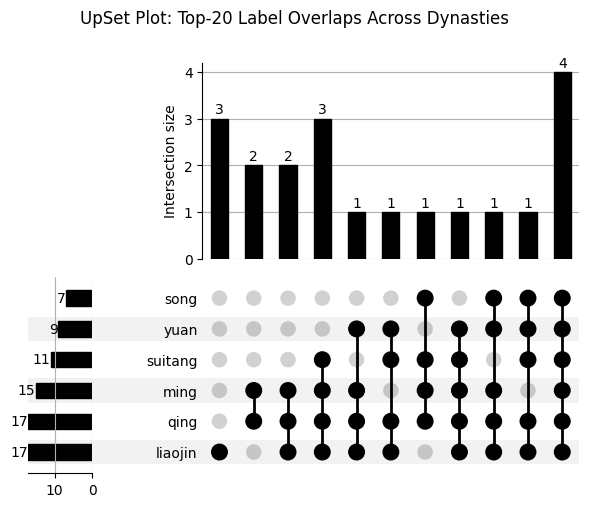

In [64]:
# 准备 Top-N 标签
dynasties = [col for col in translated_boxes_df.columns if col != 'all']
N = 20
top_labels_series = translated_boxes_df[dynasties].sum(axis=1)
top_labels = top_labels_series.sort_values(ascending=False).head(N).index.tolist()

# 构建 membership 列表和标签对应关系
memberships = []
label_map = {}
for label in top_labels:
    present_in = []
    for dyn in dynasties:
        try:
            value = translated_boxes_df.loc[label, dyn]
            if isinstance(value, pd.Series):
                value = value.iloc[0]
            if pd.notna(value) and np.isscalar(value) and float(value) > 0:
                present_in.append(dyn)
        except (KeyError, IndexError):
            continue
    if present_in:
        memberships.append(present_in)
        key = tuple(sorted(present_in))
        label_map.setdefault(key, []).append(label)

# 构建 upset 数据
if memberships:
    upset_data = from_memberships(memberships, data=[1] * len(memberships))

    fig = plt.figure(figsize=(12, 8))
    UpSet(upset_data, subset_size='count', show_counts=True).plot(fig=fig)
    plt.suptitle(f'UpSet Plot: Top-{N} Label Overlaps Across Dynasties')

    # 打印并标注具体标签
    print("\n✅ 具体标签标注:")
    for key, labels in label_map.items():
        combo = '+'.join(key)
        label_list = ', '.join(labels)
        print(f"组合 {combo}: {label_list}")

    plt.show()
else:
    print("⚠ 没有可用于 UpSet 分析的标签交集数据。请检查 top_labels 和频率矩阵。")


这里的 `top20` 含义是：

从 `translated_boxes_df` 中，先把各个标签在所有朝代上的总和（sum across dynasties）计算出来，
然后按照总出现频次从高到低排序，选出前 20 个出现频率最高的标签。

换句话说，Top-20 标签 ≈ 在全局（跨朝代）范围内最常见、最重要的 20 个 motifs。 

这些标签之后被用来分析它们在各个朝代之间的分布和交集情况，
也就是：
- 哪些标签在多个朝代都有？
- 哪些标签只在个别朝代出现？

但是因为每个朝代的数量不一样，所以这个是否有参考价值值得讨论

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_72418/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


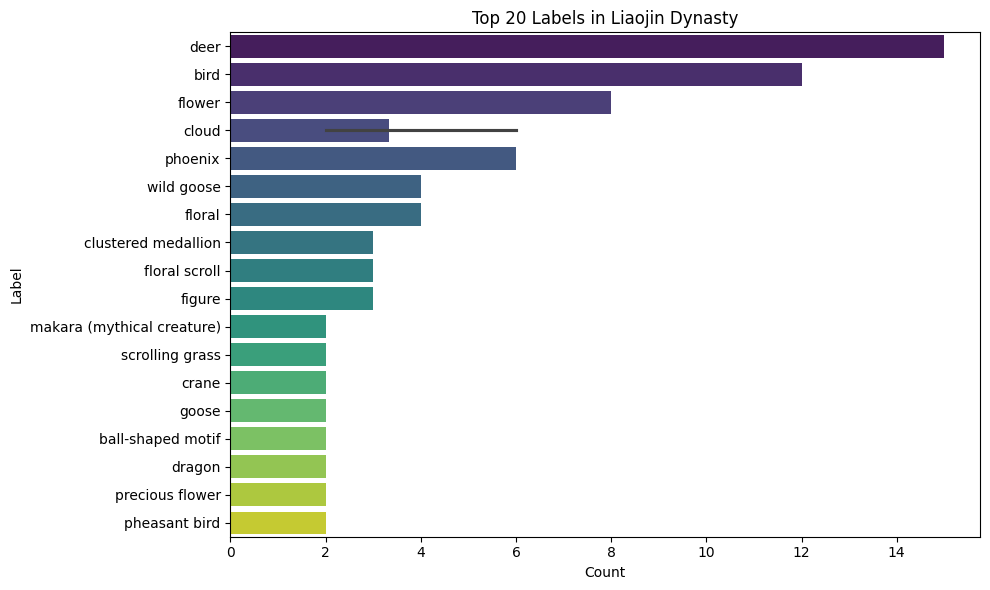

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_72418/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


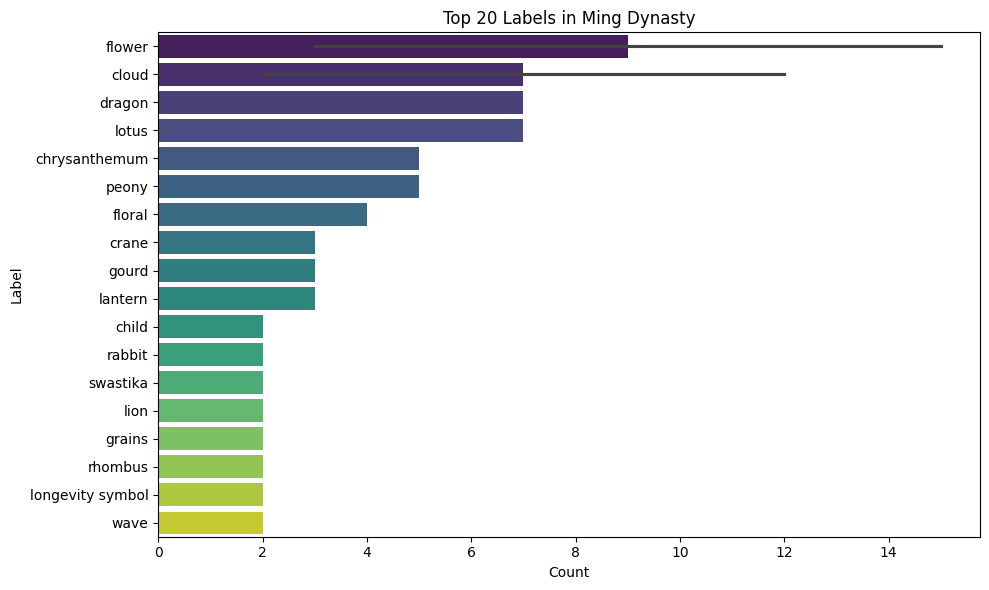

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_72418/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


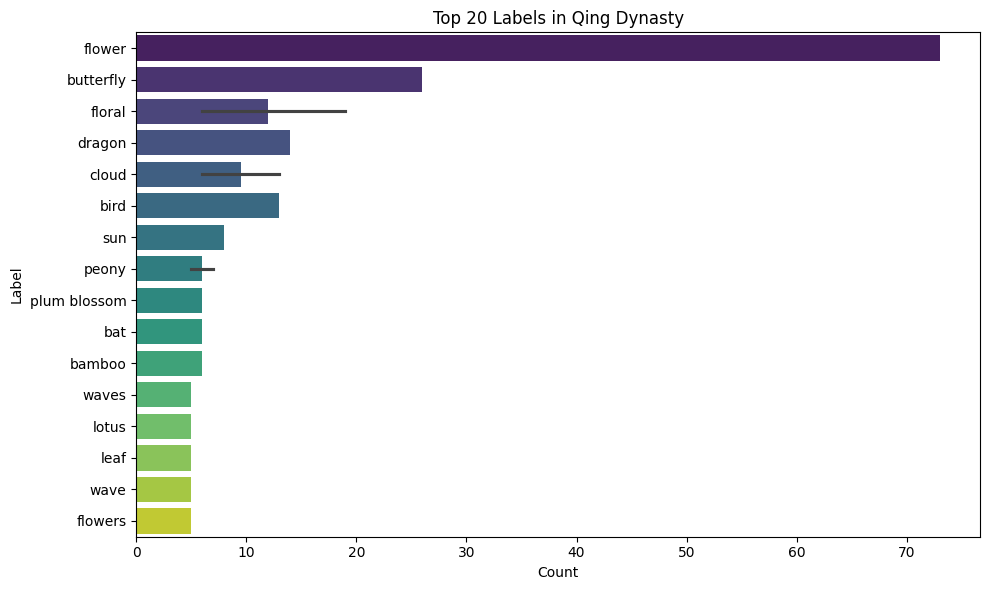

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_72418/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


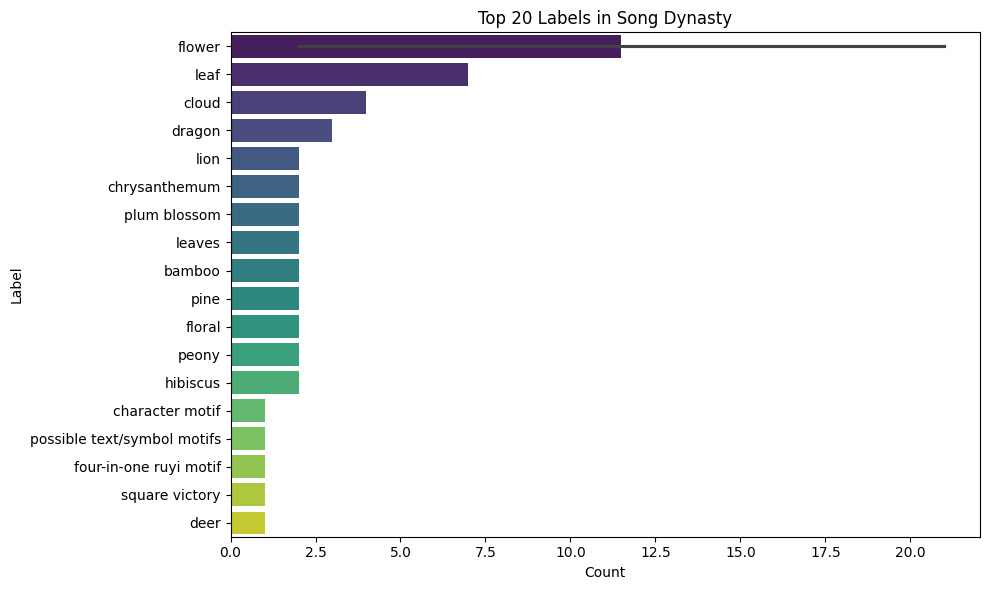

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_72418/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


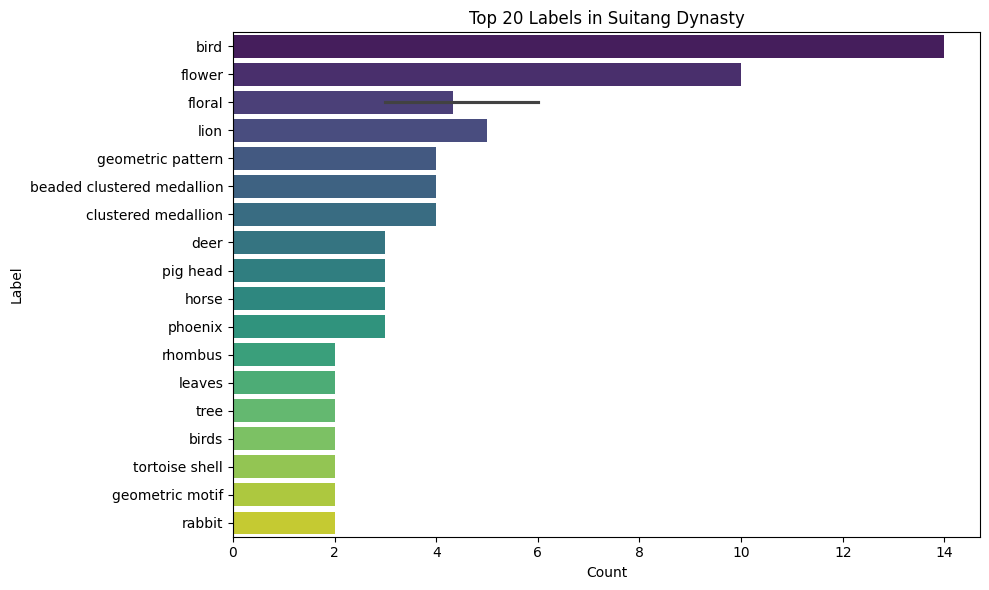

/var/folders/mf/3rb2ryr570v816gw_89qbt1c0000gn/T/ipykernel_72418/710101740.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_plot, x='count', y='label', palette='viridis')


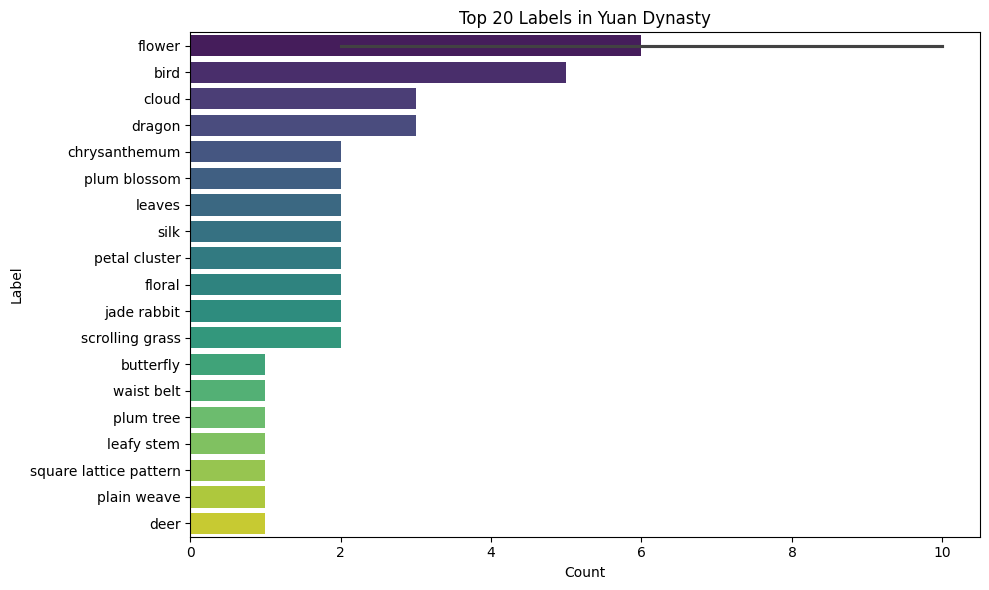

In [66]:
dynasties = [col for col in translated_boxes_df.columns if col != 'all']

for dynasty in dynasties:
    top20 = translated_boxes_df[dynasty].sort_values(ascending=False).head(20)
    df_plot = pd.DataFrame({'label': top20.index, 'count': top20.values})
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df_plot, x='count', y='label', palette='viridis')
    plt.xlabel('Count')
    plt.ylabel('Label')
    plt.title(f'Top 20 Labels in {dynasty.capitalize()} Dynasty')
    plt.tight_layout()
    plt.show()